In [1]:
import gym
import numpy as np

## Load the environment

In [2]:
env = gym.make('FrozenLake-v0')

The environment is a 4 * 4 grid over which the agent traverses so we should expect there to be 16 possible states:

In [3]:
env.observation_space.n

16

In each state, we are able to take 4 possible actions, move up, down, left, or right

In [4]:
env.action_space.n

4

## Implement Q-Table learning algorithm
In its simplest implementation, Q-Learning is a table of values for every state (row) and action (column) possible in the environment. Within each cell of the table, we learn a value for how good it is to take a given action within a given state. In the case of the FrozenLake environment, we have 16 possible states and 4 possible actions, giving us a 16x4 table of Q-values. We start by initializing the table to be uniform (all zeros), and then as we observe the rewards we obtain for various actions, we update the table accordingly.

First, let's initialise our Q table will zeros 

In [5]:
Q = np.zeros([env.observation_space.n,
              env.action_space.n])
Q

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

Now set our learning parameters

In [6]:
lr = 0.8
y = 0.95
num_episodes = 2000

We maintain a list to contain our total rewards and steps per episode

In [7]:
rList = []

and now for the learning loop itself

In [10]:
for i in range(num_episodes):
    # Reset te environment and get first new observations
    s = env.reset()
    rAll = 0
    d = False
    j = 0
    # The Q-Table learning algorithm
    while j < 99:
        j+=1
        # Choose an action by greedily (with noise) picking
        # from the Q table
        a = np.argmax(Q[s,:] + 
                      np.random.randn(1,env.action_space.n) *
                     (1./(i+1)))
        # Get a new state and reward from the environment
        s1, r, d, _ = env.step(a)
        # Update Q-Table with new knowledge
        Q[s,a] = Q[s,a] + lr*(r + y*np.max(Q[s1,:]) - Q[s,a])
        rAll+=r
        s = s1
        if d:
            break
    rList.append(rAll)

In [11]:
print("Score over time: " +  str(sum(rList)/num_episodes))

Score over time: 1.264


In [ ]:
Q

# Q Learning with neural networks
While it is easy to have a 16x4 table for a simple grid world, the number of possible states in any modern game or real-world environment is nearly infinitely larger. For most interesting problems, tables simply don’t work. We instead need some way to take a description of our state, and produce Q-values for actions without a table: that is where neural networks come in. By acting as a function approximator, we can take any number of possible states that can be represented as a vector and learn to map them to Q-values.

In the case of the FrozenLake example, we will be using a one-layer network which takes the state encoded in a one-hot vector (1x16), and produces a vector of 4 Q-values, one for each action. Instead of directly updating our table, with a network we will be using backpropagation and a loss function. Our loss function will be sum-of-squares loss, where the difference between the current predicted Q-values, and the “target” value is computed and the gradients passed through the network. In this case, our Q-target for the chosen action is the equivalent to the Q-value computed in equation 1 above.

In [16]:
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

## Load the environment

In [17]:
env = gym.make('FrozenLake-v0')

## The Q-Network Approach

In [18]:
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape
from tensorflow.keras.optimizers import SGD

These lines establish the feed-forward part of the network used to choose actions

In [19]:
def create_q_model():
    inp = Input((16),dtype='float32')
    layer1 = Dense(4,
                   activation=None,
                   kernel_initializer = RandomUniform(0, 0.01))(inp)
    return Model(inputs=inp, outputs = layer1)

Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.

In [20]:
optimizer = SGD(learning_rate=0.01)
# nextQ = K.placeholder(shape=[1,4], dtype=tf.float32)
# loss = K.sum(K.square(nextQ - m.output))
# updateModel = opt.minimize(loss, m.trainable_weights)

In [91]:
# Set learning parameters
y = .99
e = 0.1
num_episodes = 5000

In [92]:
#create lists to contain total rewards and steps per episode
jList = []
rList = []
eList = []
lossList = []
targetQsList = []
QsList = []

In [93]:
model = create_q_model()

In [94]:
for i in range(num_episodes):
    #Reset environment and get first new observation
    state = env.reset()
    episode_reward = 0
    d = False
    j = 0
    while j < 99:
        j+=1
        # Choose an action by greedily (with e chance of random action) 
        if np.random.rand(1) < e:
            # take random action
            action = env.action_space.sample()
        else:
            state_array = np.identity(16)[state:state+1]
            Qs = model(state_array, training=False)
            # Take best action
            action = tf.argmax(Qs[0]).numpy()
        
        # Get new state and reward from environment
        next_state,r,d,_ = env.step(action)
        
        # Obtain the Q' values by feeding the new state through 
        # our network
        next_state_array = np.identity(16)[next_state:next_state+1]
        nextQs = model(next_state_array, training=False)
        # Obtain maxQ' and set our target value for chosen action.
        max_next_q = tf.argmax(nextQs[0]).numpy()
        targetq = r + y*max_next_q
        
        with tf.GradientTape() as tape:
            state_array = np.identity(16)[state:state+1]
            Qs = model(state_array, training=False)
            loss = tf.reduce_sum(tf.square(targetq - Qs))
            lossList.append(loss)
            QsList.append(Qs)
            targetQsList.append(targetq)
        # Backprop
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        episode_reward+=r
        state = next_state
        
        if d:
            e = 1./((i/50) + 10)
            break
    jList.append(j)
    rList.append(episode_reward)
    eList.append(e)
print("Percentage of successfull episode: " + 
      str(sum(rList)/ num_episodes) + "%")
        

Percentage of successfull episode: 0.009%


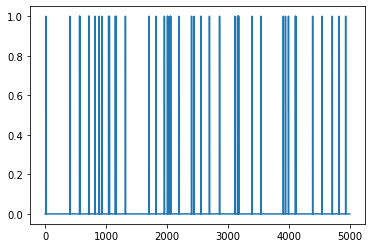

In [95]:
plt.plot(rList)

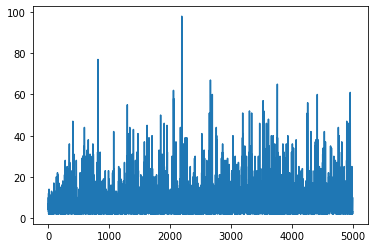

In [96]:
plt.plot(jList)

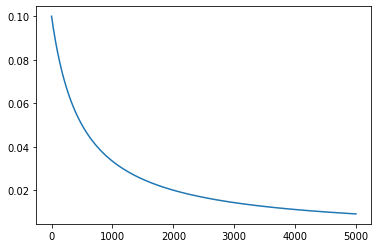

In [97]:
plt.plot(eList)

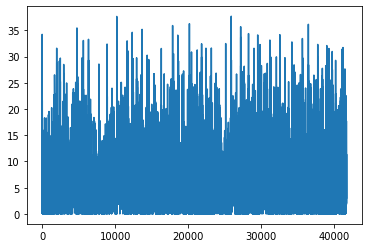

In [98]:
plt.plot(lossList)

In [99]:
[x.numpy() for x in QsList[:5]]

[array([[0.00616271, 0.00834068, 0.00987061, 0.00806533]], dtype=float32),
 array([[0.04246663, 0.04370918, 0.04909004, 0.04571544]], dtype=float32),
 array([[0.10432959, 0.0985105 , 0.10121664, 0.10456065]], dtype=float32),
 array([[0.21895641, 0.21337008, 0.21596798, 0.21917823]], dtype=float32),
 array([[0.1580216 , 0.15414931, 0.15653723, 0.1578979 ]], dtype=float32)]

In [100]:
[x.numpy() for x in QsList[-5:]]

[array([[1.6865478, 1.6865479, 1.6865479, 1.686548 ]], dtype=float32),
 array([[0.971861 , 0.9718609, 0.9718609, 0.9718607]], dtype=float32),
 array([[1.5996487, 1.5996487, 1.5996487, 1.5996487]], dtype=float32),
 array([[1.5356628, 1.5356628, 1.5356628, 1.5356629]], dtype=float32),
 array([[0.8702804 , 0.87028027, 0.8702802 , 0.87028   ]], dtype=float32)]

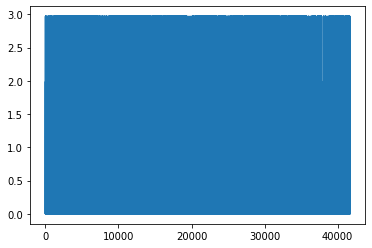

In [101]:
plt.plot(targetQsList)